In [1]:
from vtk import *
from vtk.util import numpy_support as VN
import meshio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import linecache
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
dpi=600
fig_fmt=['svg']
# path----------
path_figures='../../../../../_figures'

## 1. Read and plot mesh information
Convert OpenFOAM mesh to vtk file format and then read it and plot it.

In [4]:
# read internal data file generated by foamToVTK utility
def readInternal(vtkfile, m2mm=100):
    data=meshio.read(vtkfile)
    cells=data.cells[0].data
    points=data.points
    cells_rect=np.zeros((cells.shape[0],4),dtype=int)
    for i in range(0,cells.shape[0]):
        points_cell=points[cells[i]]
        ind_front=(points_cell[:,2]==points_cell[:,2].max())
        cells_rect[i,:]=cells[i,ind_front]
    cells_rect=cells_rect[:,[0,1,3,2]] # correct node connection order to construct rectangule
    x,y,z=points[:,0],points[:,1],points[:,2]
    print("nPoints: %d, nPoints_2D: %d, nCells: %d"%(len(points), len(points)/2, len(cells)))
    return x*m2mm, y*m2mm,z*m2mm, cells_rect
# read OpenFOAM poly Mesh
# return a python dict {'nNodes':[], 'index':[]}
def readFaces(caseDir):
    file_faces='%s/constant/polyMesh/faces'%(caseDir)
    alldata=linecache.getlines(file_faces)
    linecache.clearcache()
    nFaces,face_start,face_end=0,0,0
    for i in range(0,len(alldata)):
        alldata[i]=alldata[i].replace('\n','')
        if(alldata[i]=='('):
            nFaces=int(alldata[i-1])
            face_start=i+1
        elif(alldata[i]==')'):
            face_end=i-1
    if(not nFaces==(face_end-face_start+1)):
        print('The faces file of case %s maybe not correct, because the face number is not consistant'%(caseDir))
    # read point index of each face
    faces={'nNodes':[],'index':[]}
    for i in range(face_start, face_end+1):
        n=int(alldata[i].split('(')[0])
        index=alldata[i].split('(')[1].split(')')[0].split(' ')
        faces['nNodes'].append(n)
        faces['index'].append(np.array(index,dtype=int))
    return faces
# read owner 
# return a int array, the length is equal to number of all faces
def readOwner(caseDir):
    file_faces='%s/constant/polyMesh/owner'%(caseDir)
    alldata=linecache.getlines(file_faces)
    linecache.clearcache()
    nFaces,face_start,face_end=0,0,0
    for i in range(0,len(alldata)):
        alldata[i]=alldata[i].replace('\n','')
        if(alldata[i]=='('):
            nFaces=int(alldata[i-1])
            face_start=i+1
        elif(alldata[i]==')'):
            face_end=i-1
    if(not nFaces==(face_end-face_start+1)):
        print('The faces file of case %s maybe not correct, because the face number is not consistant'%(caseDir))
    # read point index of each face
    owners=np.array(alldata[face_start:face_end+1], dtype=int)
    return owners
# read neighbour 
# return a int array, the length is equal to number of internal faces
def readNeighbour(caseDir):
    file_faces='%s/constant/polyMesh/neighbour'%(caseDir)
    alldata=linecache.getlines(file_faces)
    linecache.clearcache()
    nFaces,face_start,face_end=0,0,0
    for i in range(0,len(alldata)):
        alldata[i]=alldata[i].replace('\n','')
        if(alldata[i]=='('):
            nFaces=int(alldata[i-1])
            face_start=i+1
        elif(alldata[i]==')'):
            face_end=i-1
    if(not nFaces==(face_end-face_start+1)):
        print('The faces file of case %s maybe not correct, because the face number is not consistant'%(caseDir))
    # read point index of each face
    neighbours=np.array(alldata[face_start:face_end+1], dtype=int)
    return neighbours
# read boundary patches information 
# return a python dict {'name':[], 'nFaces':[], 'startFace':[], 'type':[], 'index':[]}
def readBoundary(caseDir, nAllFaces=None):
    file_boundary='%s/constant/polyMesh/boundary'%(caseDir)
    alldata=linecache.getlines(file_boundary)
    linecache.clearcache()
    nBoundaries, start, end=0,0,0
    boundaries={'name':[], 'nFaces':[], 'startFace':[], 'type':[],'index':[]}
    for i in range(0,len(alldata)):
        alldata[i]=alldata[i].replace('\n','')
        if(alldata[i]=='('):
            nBoundaries=int(alldata[i-1])
            start=i+1
        elif(alldata[i]==')'):
            end=i
    # get start line and end line of each patch
    start_patch,end_patch=[],[]
    for i in range(start,end):
        if(alldata[i][-1]=='{'): # a patch start
            start_patch.append(i)
        if(alldata[i][-1]=='}'):
            end_patch.append(i)
    if((not (nBoundaries==len(start_patch))) & (not (nBoundaries==len(start_patch)))):
        print('boundary file parse failure, because boundary number are not consistant: %f'%(caseDir))
    for start, end in zip(start_patch, end_patch):
        boundaries['name'].append(alldata[start-1].split()[0])
        for i in range(start, end):
            if('type' in alldata[i]):
                boundaries['type'].append(alldata[i].split()[1].split(';')[0])
            if('nFaces' in alldata[i]):
                boundaries['nFaces'].append(int(alldata[i].split()[1].split(';')[0]))
            if('startFace' in alldata[i]):
                boundaries['startFace'].append(int(alldata[i].split()[1].split(';')[0]))
    index_allBoundaries=[]
    for n, start in zip(boundaries['nFaces'],boundaries['startFace']):
        index = np.arange(start, n+start).tolist()
        boundaries['index'].append(index)
        index_allBoundaries = index_allBoundaries +index
    print('nBoundaries: %d, '%(nBoundaries), boundaries['name'])
    # calculate all internal faces index
    index_internalFaces=[]
    if(not nAllFaces==None):
        # get all index of all internal faces
        inds_faces=np.array([True]*nAllFaces)
        inds_faces[index_allBoundaries]=False
        inds_internalFaces=(inds_faces==True)
        index_faces=np.arange(0,nAllFaces)
        index_internalFaces=index_faces[inds_internalFaces]
        print('nInternalFaces: %d'%(len(index_internalFaces)))
    return boundaries,index_internalFaces

**Interesting and smart design! the internal face index is consecutive and from zero.**

nPoints: 132, nPoints_2D: 66, nCells: 50
nBoundaries: 6,  ['left', 'right', 'top', 'bottom', 'front', 'back']
nInternalFaces: 85
24 25


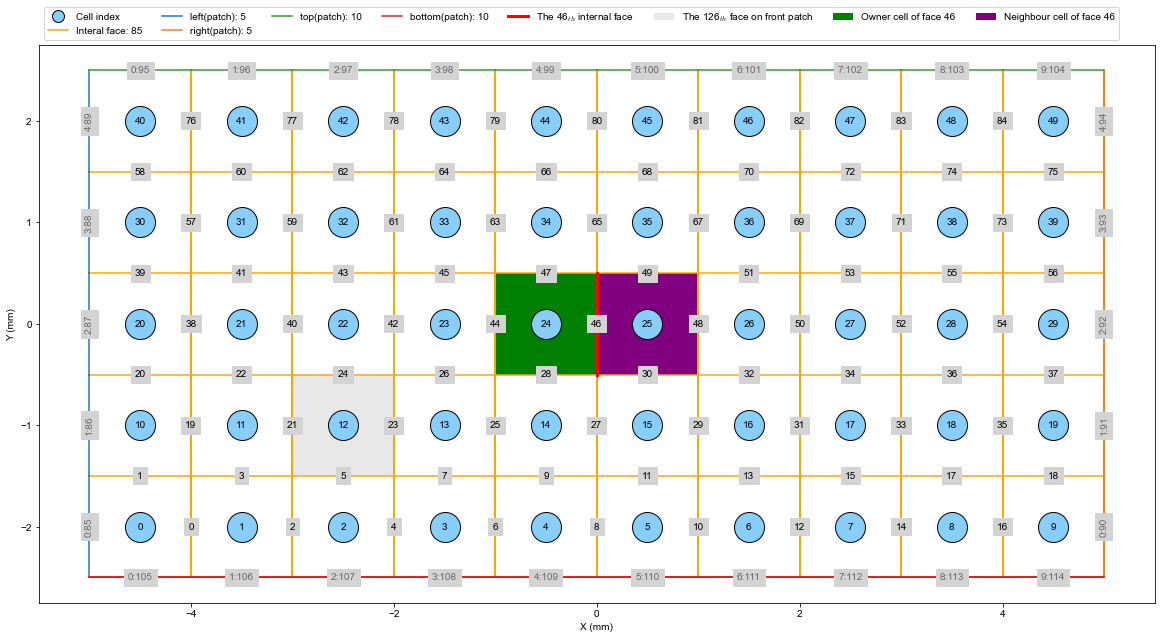

In [6]:
caseName='regularBox'
caseDir='../'
internalMesh = '%s/VTK/regularBox_10.vtk'%(caseDir)
# get mesh data
x, y, z, cells_rect=readInternal(internalMesh)
faces = readFaces(caseDir)
owners = readOwner(caseDir)
neighbours = readNeighbour(caseDir)
boundaries, index_internalFaces = readBoundary(caseDir,len(faces['nNodes']))

# plot 
fig=plt.figure(figsize=(20, 12))
ax=plt.gca()

# 1. plot front face (rectangle) of each cell and cell index in the rect center
for i in range(0,len(cells_rect)):
    rect=cells_rect[i]
    ax.fill(x[rect],y[rect],ec='None',fc='None')
    if(i==0):
        label='Cell index'
    else:
        label=None
    ax.plot(x[rect].mean(), y[rect].mean(),'o',mfc='lightskyblue',mec='k',ms=30,label=label)
    ax.text(x[rect].mean(), y[rect].mean(),str('%d'%(i)), va='center',ha='center')
# 2. plot face of the front patch, startFace and nFaces of a patch can be found in constant/polyMesh/boundary file
index_face_front=115+11
ax.fill(x[faces['index'][index_face_front]],y[faces['index'][index_face_front]],fc='lightgray', alpha=0.5, label='The %d$_{th}$ face on front patch'%(index_face_front))
# 3. plot all internal face 
for i in range(0,len(index_internalFaces)):
    index_face_internal = index_internalFaces[i]
    if(i==0):
        label='Interal face: %d'%(len(index_internalFaces))
    else:
        label=None
    index_points_internalFace=faces['index'][index_face_internal]
    x_tmp,y_tmp=x[index_points_internalFace], y[index_points_internalFace]
    ax.plot(x_tmp,y_tmp,'orange',label=label)
    # rot= 90 if(x_tmp[0]==x_tmp[1]) else 0
    ax.text(x_tmp.mean(),y_tmp.mean(),'%d'%(index_face_internal),va='center',ha='center',color='k',bbox={'color':'lightgray'})
# 4. plot all boundary patches
for name, patchType, patchIndex,lc in zip(boundaries['name'],boundaries['type'],boundaries['index'],plt.rcParams['axes.prop_cycle'].by_key()['color']):
    
    if((name=='front') | (name=='back')): # skip front and back patches, this is a 2D case!!!
        continue
    for i in range(0,len(patchIndex)):
        index_face_patch = patchIndex[i]
        if(i==0):
            label='%s(%s): %d'%(name,patchType,len(patchIndex))
        else:
            label=None
        index_points_patchFace=faces['index'][index_face_patch]
        x_tmp,y_tmp=x[index_points_patchFace], y[index_points_patchFace]
        ax.plot(x_tmp,y_tmp,color=lc,label=label)
        rot= 90 if(x_tmp.min()==x_tmp.max()) else 0
        ax.text(x_tmp.mean(),y_tmp.mean(),'%d:%d'%(i,index_face_patch),va='center',ha='center',rotation=rot, color='k', bbox={'color':'lightgray'}, alpha=0.5)
# 5. plot a internal face and marker its owner and neighbour cell
index_intFace = index_internalFaces[46]
ax.plot(x[faces['index'][index_intFace]], y[faces['index'][index_intFace]],'r',lw=3, label='The %d$_{th}$ internal face'%(index_intFace))
print(owners[index_intFace],neighbours[index_intFace])
ax.fill(x[cells_rect[owners[index_intFace]]],  y[cells_rect[owners[index_intFace]]], fc='green',label='Owner cell of face %d'%(index_intFace))
ax.fill(x[cells_rect[neighbours[index_intFace]]],  y[cells_rect[neighbours[index_intFace]]], fc='purple',label='Neighbour cell of face %d'%(index_intFace))

# set axis
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.axis('scaled')
leg=ax.legend(ncol=8,loc='lower left', bbox_to_anchor=[0,1])
leg.legendHandles[0]._legmarker.set_markersize(12)
fname_fig= lambda fmt: str('%s/mesh_FVM_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')

plt.show()